In [ ]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def json_to_matrix(json_file):
  with open(json_file) as f:
    data = json.load(f)
  dates = []
  categories_id = []
  categories = []
  I = len(data)
  i = 0
  for element in data:
    date, time = element["date"].split("T")
    year, month, day = date.split("-")
    time = time.split(".")[0]
    hour, min, sec = time.split(":")
    date = datetime.datetime(int(year), int(month), int(day), int(hour), int(min))
    dates.append(date)
    for category in element["categories"]:
      if len(categories_id) == 0:
        categories_id.append(category["category"]["id"])
        categories.append(category["category"]["name"])
        M = np.zeros((I, 1))
        M[0, 0] = category["percentage"]
      else:
        if category["category"]["id"] in categories_id:
          j = categories_id.index(category["category"]["id"])
          M[i, j] = category["percentage"]
        else:
          categories_id.append(category["category"]["id"])
          categories.append(category["category"]["name"])
          j = len(categories_id)-1
          column = np.zeros((I, 1))
          M = np.concatenate([M, column], axis=1)
          M[i, j] = category["percentage"]
    i += 1
  return M, dates, categories_id, categories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/data.json'
M, dates, categories_id, categories = json_to_matrix(DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.DataFrame(M, index=dates, columns=categories)
df.head()

,SECTOR Energía,Sector eléctrico,Consumo eléctrico,Impacto energético,Vulnerabilidad energética,Cambio climático,Calidad aire,Innovación,Movilidad sostenible,Gestión del agua,Redes eléctricas,Tarifas / mediciones eléctricas,Eficiencia energética,Smart Grids,GNL maritimo
2022-01-03,100.0,71.43,42.86,28.57,28.57,28.57,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2022-01-04,100.0,0.00,0.00,91.67,0.00,33.33,33.33,25.00,25.00,25.00,0.0,0.0,0.0,0.0,0.0
2022-01-09,100.0,40.00,40.00,0.00,0.00,0.00,0.00,60.00,60.00,0.00,20.0,0.0,0.0,0.0,0.0
2022-01-10,100.0,0.00,0.00,100.00,0.00,35.29,17.65,0.00,0.00,47.06,0.0,0.0,0.0,0.0,0.0
2022-01-11,100.0,0.00,0.00,92.86,0.00,21.43,0.00,7.14,7.14,71.43,0.0,0.0,0.0,0.0,0.0


In [ ]:
category = 'Cambio climático'
single_category_df = df[category]

In [ ]:
i_split = dates.index(datetime.datetime(2022, 7, 1))

train_dates = dates[:i_split]
train_data = np.array(single_category_df.iloc[:i_split]).reshape(-1, 1)

test_dates = dates[i_split:]
test_data = np.array(single_category_df.iloc[i_split:]).reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.2857 0.3333 0.     0.3529 0.2143]
Predict this y: 
[[0.3333]]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator, epochs=100)

Epoch 1/100
150/150 [==============================] - 3s 6ms/step - loss: 0.0280
Epoch 2/100
150/150 [==============================] - 1s 6ms/step - loss: 0.0245
Epoch 3/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0253
Epoch 4/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0245
Epoch 5/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0244
Epoch 6/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0244
Epoch 7/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0234
Epoch 8/100
150/150 [==============================] - 1s 6ms/step - loss: 0.0238
Epoch 9/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0246
Epoch 10/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0238
Epoch 11/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0244
Epoch 12/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0243
Epoch 13/100


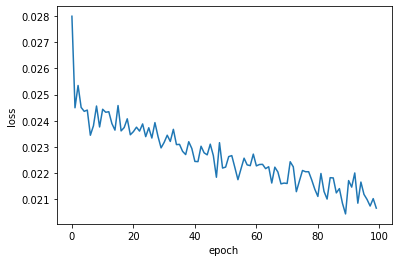

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

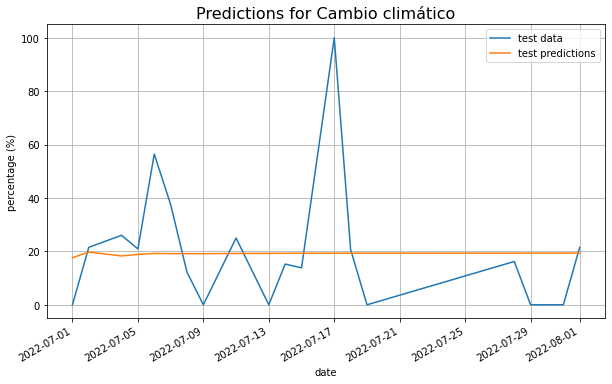

In [ ]:
test_predictions = scaler.inverse_transform(test_predictions)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(test_dates, test_data)
ax.plot(test_dates, test_predictions)
ax.set_title(f'Predictions for {category}', fontsize=16)
ax.set_xlabel('date')
ax.set_ylabel('percentage (%)')
fig.autofmt_xdate()
plt.grid()
plt.legend(['test data', 'test predictions'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test_data, test_predictions))
print(f'RMSE: {round(rmse, 2)}')

RMSE: 23.64
